In [1]:
%run ~/src/sirepo-bluesky/examples/prepare_det_env.py

In [2]:
from sirepo_bluesky.sirepo_bluesky import SirepoBluesky
from sirepo_bluesky.sirepo_ophyd import BeamStatisticsReport, create_classes

connection = SirepoBluesky("http://localhost:8000")

data, schema = connection.auth("shadow", "00000002")
classes, objects = create_classes(connection.data,
                                  connection=connection)
globals().update(**objects)

print(f"Number of points before change: {data['models']['simulation']['npoint']}")
data['models']['simulation']['npoint'] = 50000
print(f"Number of points after change: {data['models']['simulation']['npoint']}")


Number of points before change: 100000
Number of points after change: 50000


In [3]:
from ophyd import Component as Cpt
from ophyd import Signal



motors = [kbv.x_rot, kbv.offz, kbh.x_rot, kbh.offz]

n_dim = len(motors)

motor_bounds = np.array([[-0.05,+0.05],
                         [-0.5,+0.25],
                         [-0.05,+0.05],
                         [-0.5,+0.25]]).T

motor_sparse = np.c_[[_.ravel() for _ in np.meshgrid(*np.linspace(*motor_bounds, 3).T)]]
scan_path = motor_sparse

params = np.zeros((0, n_dim))
values = np.zeros((0, 1))
images = []

for attr in ['cx','cy','sx','sy','density']:
    getattr(w9, attr).kind = 'hinted'
for motor in motors:
    motor.kind = 'hinted'

In [83]:
from scipy.stats import qmc

sampler = qmc.Sobol(d=n_dim, scramble=False)

random_params = sampler.random(n=2**12) * motor_bounds.ptp(axis=0) + motor_bounds.min(axis=0)

In [4]:
params = np.zeros((0, n_dim))
values = np.zeros((0, 1))

In [5]:
x = 30 * 30
y = 1

x**2/y

810000.0

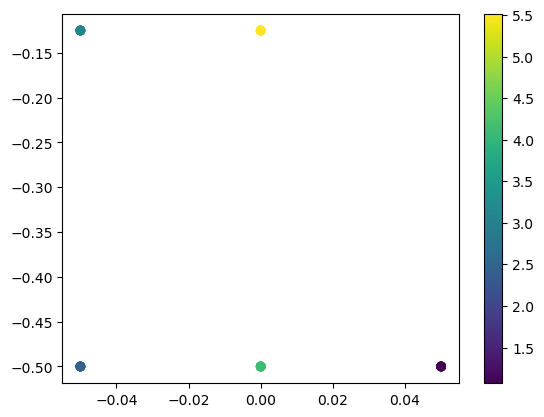

In [6]:
hdr     = db[-1]
tbl     = hdr.table()


plt.scatter(tbl.kbv_x_rot, tbl.kbv_offz, c=np.log(tbl.w9_density))
plt.colorbar()

In [7]:
def get_beam_stats(im, extents, thresh=np.exp(-2), area_method='convex'):

    W = im.copy()
    W[W < thresh * W.max()] = 0

    nx, ny = im.shape
    X, Y = np.meshgrid(np.linspace(*extents[0],nx), np.linspace(*extents[1],ny), indexing='ij')

    cx = np.sum(W * X) / np.sum(W)
    cy = np.sum(W * Y) / np.sum(W)
    
    sx = np.sqrt(np.sum(W * np.square(X-cx)) / np.sum(W))
    sy = np.sqrt(np.sum(W * np.square(Y-cy)) / np.sum(W))

    return cx, cy, sx, sy, im.sum()

In [8]:
def get_log_loss(im, extents):
    
    cx, cy, sx, sy, pixsum = get_beam_stats(im, extents)
    
    return np.log(sx * sy)

In [67]:
import sklearn

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, ConstantKernel, Matern, RationalQuadratic

kernel = 1.1 * RBF(length_scale=motor_bounds.ptp(axis=0),length_scale_bounds=(1e-2,1e0)) + WhiteKernel(noise_level=1e-2,noise_level_bounds=(1e-6,1e-1))
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0, n_restarts_optimizer=3)

In [68]:
position_readback = np.array([motor.get() for motor in motors])

In [79]:
n_per_subscan = 11
n_path = 1024 # this is fast, so we can have a lot of these

sx = Signal(name='sigma_x')

for i in range(1):

    (uid,)  = RE(bp.list_scan([w9], 
                              motors[0], scan_path[0],
                              motors[1], scan_path[1],
                              motors[2], scan_path[2],
                              motors[3], scan_path[3]))

    hdr     = db[uid]
    tbl     = hdr.table(fill=False)
    _params = tbl[[motor.name for motor in motors]].values
    _values = - np.log(tbl.w9_density.values)
    params  = np.r_[params, _params]
    values  = np.r_[values, _values[:,None]]
    print(params.shape, values.shape)
    gpr.fit(params, values)
    print(gpr.kernel_)
    position_readback = np.array([motor.get() for motor in motors])

    from scipy.stats import qmc

    sampler = qmc.Sobol(d=n_dim, scramble=False)

    random_params = sampler.random(n=2**12) * motor_bounds.ptp(axis=0) + motor_bounds.min(axis=0)

    _estimates, _uncertainties = gpr.predict(random_params, return_std=True)
    _potential = _estimates - 2 * _uncertainties
    
    scan_path = random_params[_potential.argmin(), None].T
    
    # make paths to those points from the current position
    #paths = np.linspace(position_readback[None], potential_endpoints, n_per_subscan)

    # which of these contains the most appealing point? here it's the best potential predicted solution, but if we are 
    # focused on learning it could be the largest predicted sigma.
    #path_estimates, path_uncertainties = [res.reshape(paths.shape[:2]) for res in gpr.predict(paths.reshape(-1, n_dim), return_std=True)]
    #path_potentials = np.abs(path_estimates - 2 * path_uncertainties)

    #scan_path = paths[:,path_potentials.min(axis=0).argmin()].T
    print(scan_path, _potential.min(), values.min()) 



Transient Scan ID: 27     Time: 2022-10-27 13:53:11
Persistent Unique Scan ID: 'd8cb4afd-dfac-468c-92a6-ac7c6b24a401'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time |  kbv_x_rot |   kbv_offz |  kbh_x_rot |   kbh_offz |      w9_cx |      w9_cy |      w9_sx |      w9_sy | w9_density |    w9_mean |
+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
|         1 | 13:53:15.8 |      0.000 |     -0.125 |      0.000 |     -0.125 |     99.082 |   -120.374 |      6.389 |      1.324 |    238.984 |      0.202 |
+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
generator list_scan ['d8cb4afd'] (scan num: 27)



(107, 4) (107, 1)
1.41

/home/user/anaconda3/envs/sirepo-bluesky/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


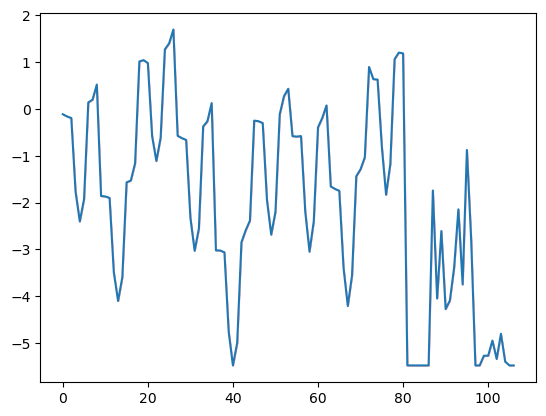

In [80]:
est, err = gpr.predict(params, return_std=True)

plt.fill_between(np.arange(len(est)), est-err, est+err, color='r', alpha=0.25)
plt.plot(values)

In [51]:
from scipy.stats import qmc

sampler = qmc.Sobol(d=len(motors), scramble=False)

random_params = sampler.random(n=1024) * motor_bounds.ptp(axis=0) + motor_bounds.min(axis=0)

_estimates, _uncertainties = gpr.predict(random_params, return_std=True)
_potential = _estimates - 2 * _uncertainties

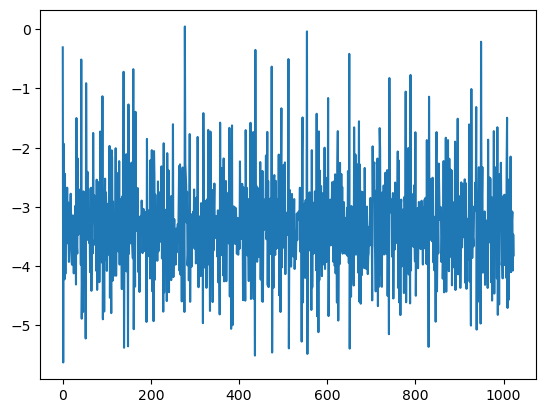

In [52]:
plt.plot(_potential)

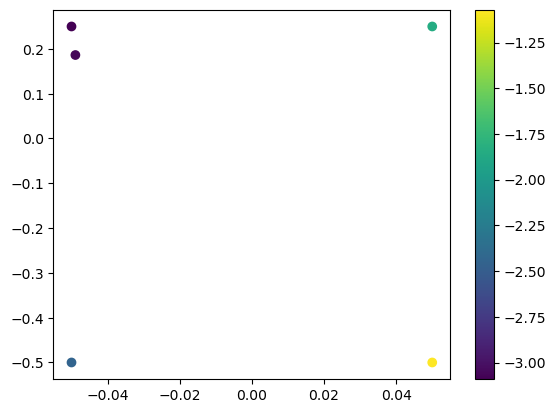

In [107]:
plt.scatter(*params.T, c=values)

plt.colorbar()

In [31]:
motor_sparse

array([[-0.05,  0.  ,  0.05, -0.05,  0.  ,  0.05, -0.05,  0.  ,  0.05],
       [-0.2 , -0.2 , -0.2 ,  0.  ,  0.  ,  0.  ,  0.2 ,  0.2 ,  0.2 ]])

In [32]:
bp.list_scan

<function bluesky.plans.list_scan(detectors, *args, per_step=None, md=None)>

In [33]:
from bluesky.simulators import plot_raster_path

{'path': <matplotlib.lines.Line2D at 0x7fa036877b20>,
 'events': <matplotlib.collections.PathCollection at 0x7fa0367a6970>}

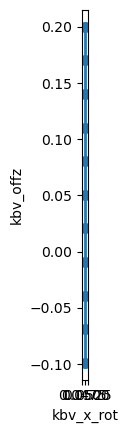

In [34]:
fig, ax = plt.subplots(1,1)
#ax.set_xlim(*motor_bounds[0])
plot_raster_path(bp.list_scan([w9], 
                          motors[0], scan_path[0],
                          motors[1], scan_path[1]), motors[0].name, motors[1].name, ax=ax)





Transient Scan ID: 2     Time: 2022-10-27 10:56:47
Persistent Unique Scan ID: '95825634-3a8c-42cf-9bc2-eb4c40f9524b'
New stream: 'primary'
+-----------+------------+------------+------------+------------+
|   seq_num |       time |  kbv_x_rot |   kbv_offz |    w9_mean |
+-----------+------------+------------+------------+------------+
|         1 | 10:56:54.8 |      0.050 |      0.200 |      0.218 |
|         2 | 10:57:01.4 |      0.050 |      0.170 |      0.265 |
|         3 | 10:57:09.0 |      0.050 |      0.140 |      0.303 |
|         4 | 10:57:16.7 |      0.050 |      0.110 |      0.335 |
|         5 | 10:57:24.2 |      0.050 |      0.080 |      0.359 |


(9, 2) (9, 1)


/home/user/anaconda3/envs/sirepo-bluesky/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


14.6**2 * RBF(length_scale=[0.001, 15]) + WhiteKernel(noise_level=0.0286)

In [13]:
params.shape, values.shape

((9, 2), (9, 1))

In [33]:
params[4]

array([0., 0.])

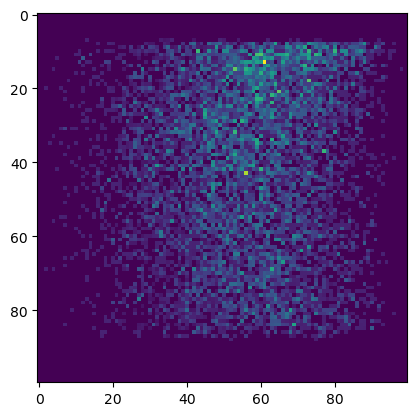

In [34]:
plt.imshow(images[4])

In [132]:
import pandas as pd

In [144]:
tbl[['w9_image', 'w9_vertical_extent', 'w9_horizontal_extent']].values

array([[array([[0., 0., 0., ..., 0., 0., 0.],
               [0., 0., 0., ..., 0., 0., 0.],
               [0., 0., 0., ..., 0., 0., 0.],
               ...,
               [0., 0., 0., ..., 0., 0., 0.],
               [0., 0., 0., ..., 0., 0., 0.],
               [0., 0., 0., ..., 0., 0., 0.]]),
        list([0.01297861044901375, 0.024677569412013677]),
        list([-0.08823541720514969, -0.04715959399228667])],
       [array([[0., 0., 0., ..., 0., 0., 0.],
               [0., 0., 0., ..., 0., 0., 0.],
               [0., 0., 0., ..., 0., 0., 0.],
               ...,
               [0., 0., 0., ..., 0., 0., 0.],
               [0., 0., 0., ..., 0., 0., 0.],
               [0., 0., 0., ..., 0., 0., 0.]]),
        list([0.03605016166984322, 0.04722747951490601]),
        list([-0.0882353045804028, -0.04715913174313719])],
       [array([[0., 0., 0., ..., 0., 0., 0.],
               [0., 0., 0., ..., 0., 0., 0.],
               [0., 0., 0., ..., 0., 0., 0.],
               ...,
        

In [134]:
stats.columns = ['cx','cy','wx','wy','pixsum']

In [ ]:
stats = pd.DataFrame([get_beam_stats(im, (ve, he)) for im, ve, he in tbl[['w9_image', 'w9_vertical_extent', 'w9_horizontal_extent']].values])

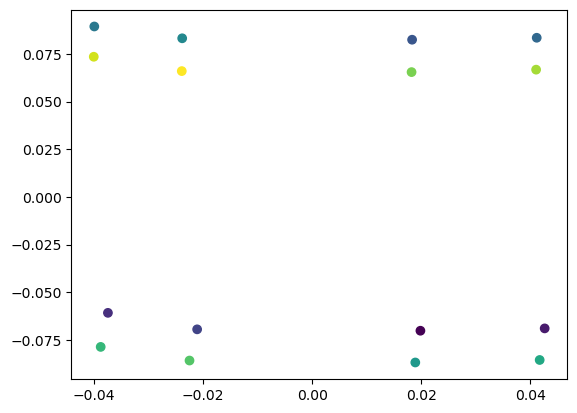

In [138]:
plt.scatter(stats.cx, stats.cy, c=stats.index)